# 📌 Convolutional Neural Networks (CNNs) - A Complete Guide

This notebook provides a **detailed breakdown** of CNN fundamentals and their application to **Fashion MNIST**. We will cover:

✔ **Mathematical foundations of CNNs**  
✔ **Preprocessing Fashion MNIST dataset**  
✔ **Building and training a CNN in PyTorch**  
✔ **Evaluating and visualizing results**

---

## 📖 1. Introduction to CNNs

### 🔹 Why Use Convolutional Neural Networks?
A **Convolutional Neural Network (CNN)** is a specialized deep learning model designed to process structured grid data, such as images. Unlike traditional fully connected neural networks, CNNs **exploit spatial hierarchies** by applying **convolutional filters** to extract features automatically.

✔ **Capture local patterns using filters**  
✔ **Reduce the number of parameters with weight sharing**  
✔ **Learn hierarchical representations (edges → textures → objects)**  
✔ **Achieve state-of-the-art performance in vision tasks**

---

## 🧮 2. Mathematical Foundation of CNNs

### 🔹 1. The Convolution Operation

A **convolution** is a mathematical operation that applies a **kernel (filter)** to an input image. Mathematically, a **2D convolution** is defined as:

$$
S(i, j) = \sum_m \sum_n X(i-m, j-n) K(m, n)
$$

where:
- **\(X\)** is the input image,
- **\(K\)** is the convolutional filter (kernel),
- **\(S(i, j)\)** is the output feature map.

Each kernel detects **specific patterns**, such as **edges, textures, or shapes**.

---

### 🔹 2. Stride and Padding

- **Stride \( s \)**: Determines how much the filter moves at each step.  
  - Stride \( s = 1 \) → Dense feature maps (more details)  
  - Stride \( s > 1 \) → Smaller feature maps (reduces computation)

- **Padding \( p \)**: Adds extra pixels around the input to preserve spatial dimensions.  
  - **"Valid" convolution**: No padding, reducing output size.  
  - **"Same" convolution**: Padding ensures output size remains the same as input.

The output feature map size can be computed as:

$$
O = \frac{(I - K + 2P)}{S} + 1
$$

where:
- \( I \) = input size,  
- \( K \) = kernel size,  
- \( P \) = padding,  
- \( S \) = stride.

---

### 🔹 3. Pooling Layer

Pooling reduces dimensionality while **retaining important features**. The two common types are:

- **Max Pooling**:
  
  $$
  P(i, j) = \max(X(i:i+k, j:j+k))
  $$

  Selects the maximum value in a window.

- **Average Pooling**:

  $$
  P(i, j) = \frac{1}{k^2} \sum X(i:i+k, j:j+k)
  $$

  Averages values in a window.

---

### 🔹 4. Fully Connected Layer

After feature extraction with convolutions, a **fully connected layer** (dense layer) maps features to class scores. Mathematically, this is represented as:

$$
y = W \cdot x + b
$$

where:
- \( W \) = weight matrix,  
- \( x \) = input vector (flattened feature map),  
- \( b \) = bias term.

The output is then passed through a **softmax function**:

$$
\hat{y}_i = \frac{e^{z_i}}{\sum_j e^{z_j}}
$$

to obtain class probabilities.

---


## 🚀 3. Preprocessing the Fashion MNIST Dataset

### 🔹 About the Dataset
Fashion MNIST is a **grayscale (28×28)** image dataset containing **10 clothing categories**:
1. T-shirt/top
2. Trouser
3. Pullover
4. Dress
5. Coat
6. Sandal
7. Shirt
8. Sneaker
9. Bag
10. Ankle boot

Each image is labeled with an integer **(0-9)**.

---

### 🔹 Data Preprocessing Steps
✔ **Normalize pixel values** (scale from [0, 255] to [0, 1])  
✔ **Reshape data** (PyTorch requires batch dimension)  
✔ **Convert to tensors**  

---


### 📌 **PyTorch Implementation of CNN for Fashion MNIST**

In [5]:
# 📦 Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [3]:
# ✅ 1. Load and Preprocess Fashion MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1,1]
])

# Download dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# ✅ 2. Define the CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)  # Flatten feature maps
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # No softmax, CrossEntropyLoss applies it
        return x

# ✅ 3. Initialize Model, Loss Function, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ✅ 4. Train the CNN Model
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}")

# ✅ 5. Evaluate the Model
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"📊 Accuracy on test set: {accuracy:.2f}%")


'# ✅ 1. Load and Preprocess Fashion MNIST Dataset\ntransform = transforms.Compose([\n    transforms.ToTensor(),  # Convert images to tensors\n    transforms.Normalize((0.5,), (0.5,))  # Normalize to range [-1,1]\n])\n\n# Download dataset\ntrain_dataset = torchvision.datasets.FashionMNIST(root=\'./data\', train=True, transform=transform, download=True)\ntest_dataset = torchvision.datasets.FashionMNIST(root=\'./data\', train=False, transform=transform, download=True)\n\n# Create DataLoader\ntrain_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)\ntest_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)\n\n# ✅ 2. Define the CNN Model\nclass CNN(nn.Module):\n    def __init__(self):\n        super(CNN, self).__init__()\n        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)\n        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)\n        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)\n        s

### 📌 PyTorch: Visualizing Fashion MNIST

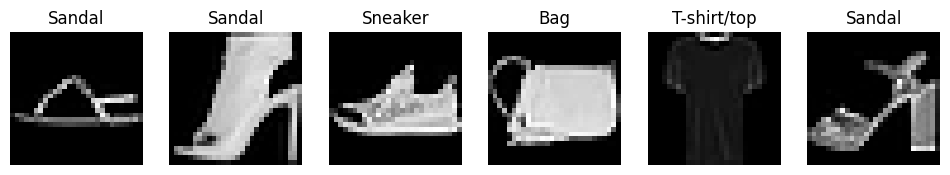

In [6]:
# ✅ 1. Load and Preprocess Fashion MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

# Create DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# ✅ 2. Visualize Sample Images
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Function to display images
def show_images(images, labels):
    images = images / 2 + 0.5  # Unnormalize from [-1,1] to [0,1]
    np_images = images.numpy()
    
    fig, axes = plt.subplots(1, 6, figsize=(12, 4))
    for i in range(6):
        axes[i].imshow(np_images[i].squeeze(), cmap="gray")
        axes[i].set_title(class_names[labels[i].item()])
        axes[i].axis("off")
    plt.show()

# Get a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
show_images(images[:6], labels[:6])


### 📌 **Keras Implementation of CNN for Fashion MNIST**

In [7]:
# 📦 Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [10]:
# ✅ 1. Load and Preprocess Fashion MNIST Dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalize pixel values to range [0,1]
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Reshape for CNN (batch, height, width, channels)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# ✅ 2. Define the CNN Model
keras_model = keras.Sequential([
    layers.Conv2D(32, kernel_size=3, activation="relu", padding="same", input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=2),
    
    layers.Conv2D(64, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=2),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")  # Softmax for multi-class classification
])

# ✅ 3. Compile the Model
keras_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# ✅ 4. Train the Model
keras_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# ✅ 5. Evaluate the Model
test_loss, test_accuracy = keras_model.evaluate(X_test, y_test)
print(f"📊 Accuracy on test set: {test_accuracy:.2f}%")


'# ✅ 1. Load and Preprocess Fashion MNIST Dataset\n(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()\n\n# Normalize pixel values to range [0,1]\nX_train = X_train.astype("float32") / 255.0\nX_test = X_test.astype("float32") / 255.0\n\n# Reshape for CNN (batch, height, width, channels)\nX_train = np.expand_dims(X_train, axis=-1)\nX_test = np.expand_dims(X_test, axis=-1)\n\n# ✅ 2. Define the CNN Model\nkeras_model = keras.Sequential([\n    layers.Conv2D(32, kernel_size=3, activation="relu", padding="same", input_shape=(28, 28, 1)),\n    layers.MaxPooling2D(pool_size=2),\n    \n    layers.Conv2D(64, kernel_size=3, activation="relu", padding="same"),\n    layers.MaxPooling2D(pool_size=2),\n\n    layers.Flatten(),\n    layers.Dense(128, activation="relu"),\n    layers.Dense(10, activation="softmax")  # Softmax for multi-class classification\n])\n\n# ✅ 3. Compile the Model\nkeras_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["a

### 📌 Keras: Visualizing Fashion MNIST

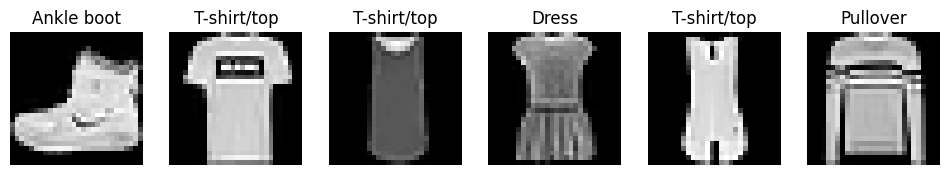

In [8]:
# ✅ 1. Load Fashion MNIST Dataset
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# ✅ 2. Visualize Sample Images
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", 
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Function to display images
def show_images(images, labels):
    fig, axes = plt.subplots(1, 6, figsize=(12, 4))
    for i in range(6):
        axes[i].imshow(images[i], cmap="gray")
        axes[i].set_title(class_names[labels[i]])
        axes[i].axis("off")
    plt.show()

# Show images
show_images(X_train[:6], y_train[:6])